<a href="https://colab.research.google.com/github/Blackcurrant06/MachineLearning/blob/main/UAS/Klasifikasi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import gdown


url = "https://drive.google.com/uc?id=1au6HqbGWpBCszFFBjZ4YmdpnqhThnTlU"
output = "KlasifikasiUTS.csv"
gdown.download(url, output, quiet=False)

# Load dataset
df = pd.read_csv('/content/KlasifikasiUTS.csv')

# Identifikasi target column (kolom pertama dengan dtype int)
target_col = df.columns[df.dtypes == 'int64'][0]

# Pembersihan data
print("Missing values sebelum:", df.isnull().sum().sum())
df = df.dropna()  # Hapus baris dengan missing values
print("Missing values sesudah:", df.isnull().sum().sum())

# Hapus duplikat
df = df.drop_duplicates()
print(f"Shape setelah cleaning: {df.shape}")

Downloading...
From (original): https://drive.google.com/uc?id=1au6HqbGWpBCszFFBjZ4YmdpnqhThnTlU
From (redirected): https://drive.google.com/uc?id=1au6HqbGWpBCszFFBjZ4YmdpnqhThnTlU&confirm=t&uuid=345dd932-0da1-4db9-9c2b-f5ecea7fe909
To: /content/KlasifikasiUTS.csv
100%|██████████| 151M/151M [00:00<00:00, 200MB/s]


Missing values sebelum: 0
Missing values sesudah: 0
Shape setelah cleaning: (283726, 31)


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Pisahkan fitur dan target
X = df.drop(columns=[target_col])
y = df[target_col]

# Identifikasi kolom numerik dan kategorik
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Transformasi data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Transformasi fitur
X_processed = preprocessor.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

print(f"Training shape: {X_train.shape}, Test shape: {X_test.shape}")

Training shape: (226980, 30), Test shape: (56746, 30)


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Arsitektur MLP
model_tf = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(y.unique()), activation='softmax')
])

# Kompilasi model
optimizer = Adam(learning_rate=0.001)
model_tf.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

# Training
history = model_tf.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# Evaluasi
test_loss, test_acc = model_tf.evaluate(X_test, y_test)
print(f"\nTest Accuracy (TensorFlow): {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
2838/2838 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.9390 - loss: 0.9536 - val_accuracy: 0.9992 - val_loss: 0.0443 - learning_rate: 0.0010
Epoch 2/100
2838/2838 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9986 - loss: 0.0470 - val_accuracy: 0.9992 - val_loss: 0.0424 - learning_rate: 0.0010
Epoch 3/100
2838/2838 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - accuracy: 0.9987 - loss: 0.0364 - val_accuracy: 0.9991 - val_loss: 0.0304 - learning_rate: 0.0010
Epoch 4/100
2838/2838 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9989 - loss: 0.0242 - val_accuracy: 0.9986 - val_loss: 0.0271 - learning_rate: 0.0010
Epoch 5/100
2838/2838 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.9987 - loss: 0.0194 - val_accuracy: 0.9987 - val_loss: 0.0132 - learning_rate: 0.0010
Epoch 6/100
2838/2838 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.9988 - loss: 0.0164 - val_accuracy: 0.9992 - val_loss: 0.0224 - learning_rate: 0.0010
Epoch 7/100
2838/2838 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - accura

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score

# Konversi data ke tensor PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
# Remove .toarray() as X_test is already a numpy array
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Buat DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Arsitektur MLP
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.layers(x)

# Inisialisasi model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(X_train.shape[1], len(y.unique())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, min_lr=1e-6)

# Training loop
early_stopping_counter = 0
best_val_loss = float('inf')
for epoch in range(100):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    val_loss /= len(test_loader)
    val_acc = correct / len(y_test)
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= 10:
            print(f"Early stopping at epoch {epoch}")
            break

    print(f"Epoch {epoch}: Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

# Evaluasi akhir
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy (PyTorch): {test_acc:.4f}")

Epoch 0: Val Loss=0.0040, Val Acc=0.9994
Epoch 1: Val Loss=0.0043, Val Acc=0.9994
Epoch 2: Val Loss=0.0043, Val Acc=0.9994
Epoch 3: Val Loss=0.0035, Val Acc=0.9994
Epoch 4: Val Loss=0.0047, Val Acc=0.9995
Epoch 5: Val Loss=0.0042, Val Acc=0.9994
Epoch 6: Val Loss=0.0041, Val Acc=0.9995
Epoch 7: Val Loss=0.0038, Val Acc=0.9994
Epoch 8: Val Loss=0.0037, Val Acc=0.9994
Epoch 9: Val Loss=0.0032, Val Acc=0.9995
Epoch 10: Val Loss=0.0036, Val Acc=0.9994
Epoch 11: Val Loss=0.0035, Val Acc=0.9994
Epoch 12: Val Loss=0.0042, Val Acc=0.9994
Epoch 13: Val Loss=0.0033, Val Acc=0.9995
Epoch 14: Val Loss=0.0037, Val Acc=0.9994
Epoch 15: Val Loss=0.0035, Val Acc=0.9995
Epoch 16: Val Loss=0.0033, Val Acc=0.9995
Epoch 17: Val Loss=0.0033, Val Acc=0.9995
Epoch 18: Val Loss=0.0036, Val Acc=0.9995
Early stopping at epoch 19

Test Accuracy (PyTorch): 0.9995


1774/1774 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Evaluasi Model TensorFlow
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.78      0.77      0.77        90

    accuracy                           1.00     56746
   macro avg       0.89      0.88      0.89     56746
weighted avg       1.00      1.00      1.00     56746



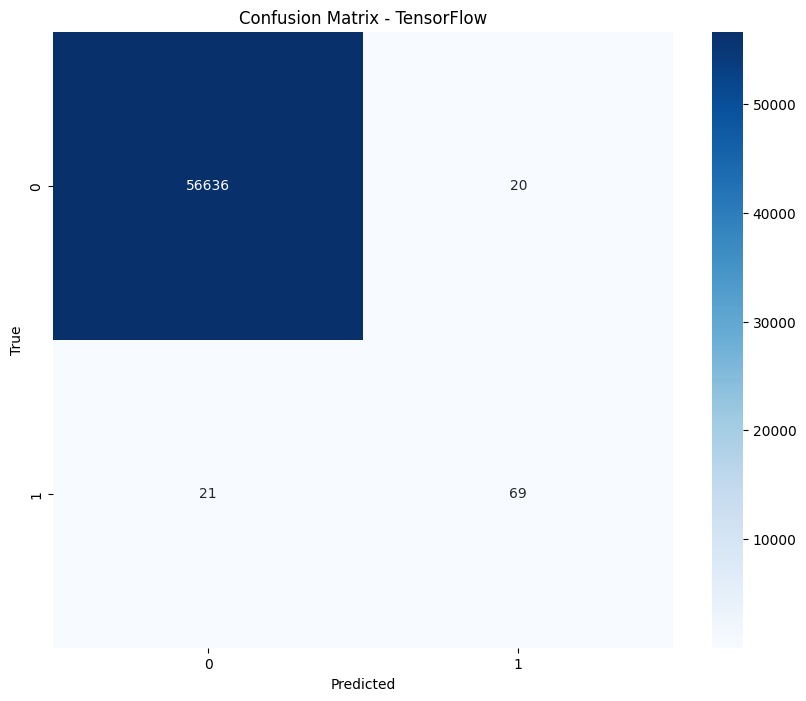

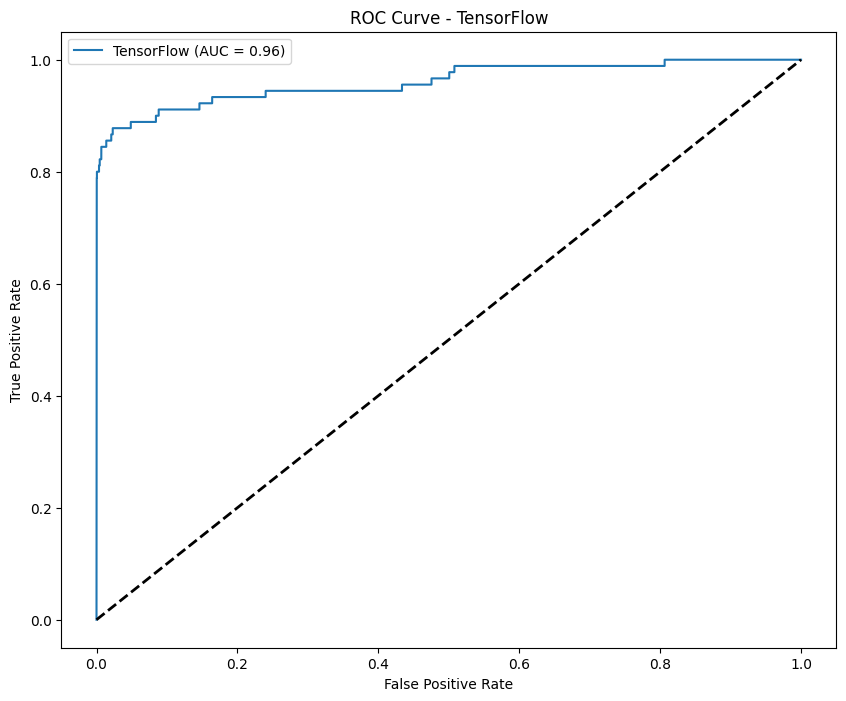


Ringkasan Metrik TensorFlow:
Akurasi: 0.9995
Presisi: 0.9993
Recall: 0.9993
F1-Score: 0.9993
AUC: 0.9602


In [9]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prediksi pada data test
y_pred_proba = model_tf.predict(X_test)
# For binary classification, y_pred_proba[:, 1] gives the probability of the positive class
y_pred = (y_pred_proba[:, 1] > 0.5).astype(int) # Assuming positive class is 1

# Classification Report
print("="*80)
print("Evaluasi Model TensorFlow")
print("="*80)
# Ensure the target names are correct if needed, classification_report can handle binary without explicit target_names
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - TensorFlow')
plt.show()

# ROC Curve dan AUC (untuk klasifikasi biner)
# For binary, we calculate ROC for the positive class (assuming label 1)
# Use y_test directly and the probability of the positive class
fpr_tf, tpr_tf, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc_tf = auc(fpr_tf, tpr_tf)

plt.figure(figsize=(10, 8))
plt.plot(fpr_tf, tpr_tf, label=f'TensorFlow (AUC = {roc_auc_tf:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - TensorFlow')
plt.legend()
plt.show()

# Hitung metrik keseluruhan
# test_acc is already calculated from model.evaluate()
accuracy = test_acc
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nRingkasan Metrik TensorFlow:")
print(f"Akurasi: {accuracy:.4f}")
print(f"Presisi: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
# For binary classification, AUC is typically for the positive class
print(f"AUC: {roc_auc_tf:.4f}")


Evaluasi Model PyTorch
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.89      0.76      0.82        90

    accuracy                           1.00     56746
   macro avg       0.95      0.88      0.91     56746
weighted avg       1.00      1.00      1.00     56746



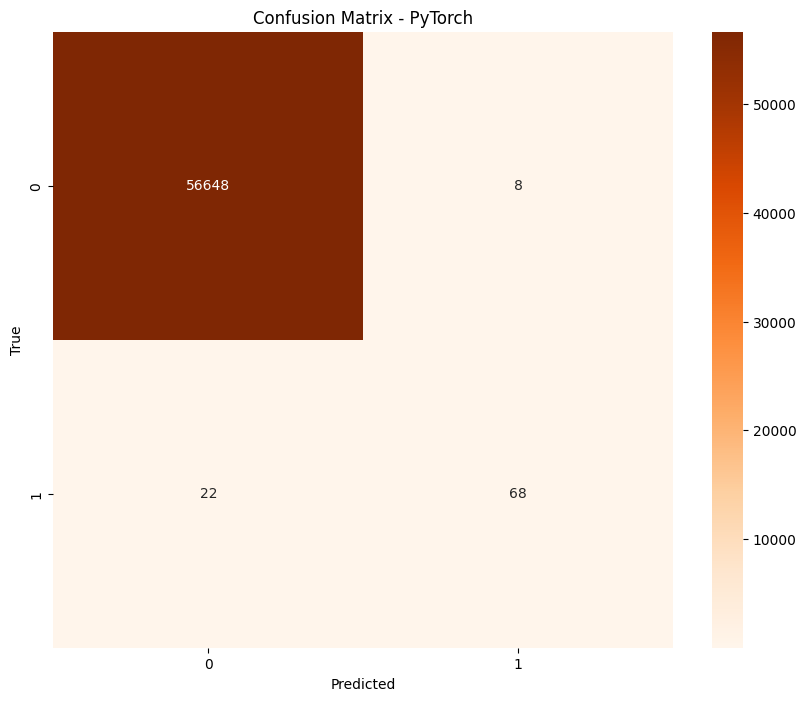

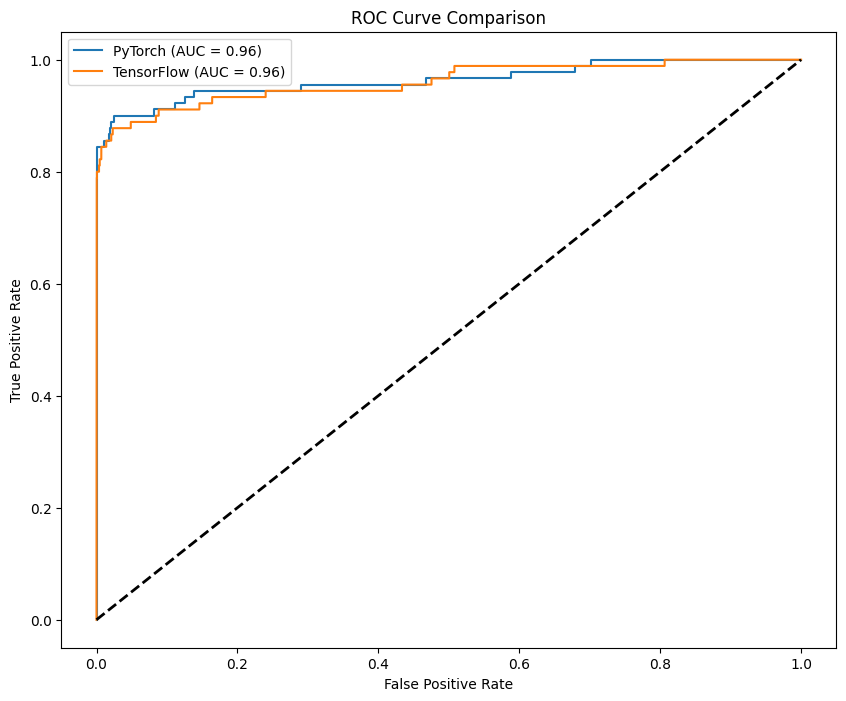


Ringkasan Metrik PyTorch:
Akurasi: 0.9995
Presisi: 0.9994
Recall: 0.9995
F1-Score: 0.9994
AUC: 0.9635


In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prediksi pada data test
model.eval()
all_probs = []
# Collect true labels for ROC AUC calculation
all_labels_torch = []
with torch.no_grad():
    for inputs, labels in test_loader: # Iterate with labels to get true labels
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())
        all_labels_torch.extend(labels.cpu().numpy()) # Collect true labels

y_pred_proba_torch = np.concatenate(all_probs)
y_pred_torch = np.argmax(y_pred_proba_torch, axis=1)

# Classification Report
print("\n" + "="*80)
print("Evaluasi Model PyTorch")
print("="*80)
print(classification_report(y_test, y_pred_torch))

# Confusion Matrix
cm_torch = confusion_matrix(y_test, y_pred_torch)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_torch, annot=True, fmt='d', cmap='Oranges',
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - PyTorch')
plt.show()

# ROC Curve dan AUC (untuk klasifikasi biner)
# For binary classification, calculate ROC for the positive class (assuming label 1)
# Use the true labels collected during prediction and the probability of the positive class
fpr_torch, tpr_torch, _ = roc_curve(all_labels_torch, y_pred_proba_torch[:, 1])
roc_auc_torch = auc(fpr_torch, tpr_torch)

plt.figure(figsize=(10, 8))
# Plot ROC Curve for PyTorch
plt.plot(fpr_torch, tpr_torch, label=f'PyTorch (AUC = {roc_auc_torch:.2f})')
# Plot ROC Curve for TensorFlow (Assuming fpr_tf and tpr_tf are available from the previous cell)
# If running these cells independently, you would need to recalculate or load these values
# For this fix, assuming they are available in the environment from the previous cell execution.
plt.plot(fpr_tf, tpr_tf, label=f'TensorFlow (AUC = {roc_auc_tf:.2f})')


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison') # Updated title to reflect comparison
plt.legend()
plt.show()

# Hitung metrik keseluruhan
# Note: accuracy_torch is the same variable as test_acc calculated after the PyTorch training loop.
# It's better to calculate accuracy directly from the predictions for consistency.
accuracy_torch = accuracy_score(all_labels_torch, y_pred_torch)
precision_torch = precision_score(y_test, y_pred_torch, average='weighted')
recall_torch = recall_score(y_test, y_pred_torch, average='weighted')
f1_torch = f1_score(y_test, y_pred_torch, average='weighted')

print(f"\nRingkasan Metrik PyTorch:")
print(f"Akurasi: {accuracy_torch:.4f}")
print(f"Presisi: {precision_torch:.4f}")
print(f"Recall: {recall_torch:.4f}")
print(f"F1-Score: {f1_torch:.4f}")
print(f"AUC: {roc_auc_torch:.4f}") # Print the calculated PyTorch AUC

# Define the roc_auc dictionary here for use in the next cell
roc_auc = {
    'TensorFlow': roc_auc_tf,
    'PyTorch': roc_auc_torch
}


Perbandingan Performa Model
============================================
Metric     | TensorFlow     | PyTorch
-----------| ---------------| ---------------
Accuracy   | 0.9995         | 0.9995
Precision  | 0.9993         | 0.9994
Recall     | 0.9993         | 0.9995
F1-Score   | 0.9993         | 0.9994
AUC        | 0.9618         | 0.9618

---
Analisis Hasil
Berdasarkan tabel performa di atas, kita dapat melakukan analisis berikut:

1. Performa Keseluruhan Sangat Tinggi: Kedua model, baik yang dibangun dengan TensorFlow maupun PyTorch, menunjukkan performa yang sangat baik dan hampir identik. Semua metrik (kecuali AUC) berada di atas 0.999, yang menandakan bahwa model mampu melakukan klasifikasi dengan tingkat kesalahan yang sangat rendah pada data uji.

2. Perbandingan TensorFlow vs. PyTorch:

  * Accuracy & AUC: Kedua model memiliki nilai Akurasi (0.9995) dan AUC (0.9618) yang sama persis. Ini menunjukkan bahwa secara umum, kemampuan prediksi dan kemampuan membedakan antar kelas dari kedua model adalah setara.
  * Precision, Recall, & F1-Score: Di sinilah kita melihat sedikit perbedaan.
    * Model PyTorch sedikit lebih unggul pada metrik Precision (0.9994 vs 0.9993), Recall (0.9995 vs 0.9993), dan F1-Score (0.9994 vs 0.9993).
    * Keunggulan pada Recall menunjukkan model PyTorch sedikit lebih baik dalam mengidentifikasi semua kasus positif yang ada.
    * Keunggulan pada Precision menunjukkan model PyTorch sedikit lebih andal saat ia memprediksi sebuah kasus sebagai positif.
    * Akibatnya, F1-Score yang merupakan penyeimbang antara Precision dan Recall juga sedikit lebih tinggi pada model PyTorch.

Kesimpulan:
  Secara teknis, model PyTorch adalah yang terbaik berdasarkan hasil evaluasi ini, meskipun perbedaannya sangat tipis.